# Info

Nel codice ci sono varie celle di testo, ma la spiegazione generale di quello che ho fatto la lascio qui.

Ho testato vari modelli per trovare un modello che rispondesse meglio a questo dataset e riuscisse meglio a fare una predizione.

I modelli che hanno risposto meglio sono stati il Random Tree Classifier, il Random Forest Classifier e il LGBM Classifier (Light Gradient Boosting Machine).

Ho deciso di scegliere il modello LGBM in quanto produceva il risultato migliore, andava meno in overfitting ed ero curioso di usare un nuovo modello. Random Forest è il primo che ho usato, ma andava fortemente in overfitting e, a livello di F1-macro score, era 3 punti percentuali sotto LGBM. Random Tree era anche una buona opzione: 89 di accuracy e 70 di F1-macro, ma alla fine sono stato tentato dal modello che performava meglio.

Come feature selection sono andato a mano principalmente e alla fine ho anche visto quali feature utilizzavano di più i modelli. In generale ho notato che la maggior parte delle feature aveva poca utilità, ma che nel totale si potevano tenere quasi tutte.Ho pensato anche di usare il metodo PCA, che è stato spiegato in classe, ma alla fine non l'ho implementato, visto che dopo aver testato manualmente tante feature sono arrivato alla conclusione che, anche se avessi trovato le feature migliori, non avrebbe performato particolarmente meglio e, a causa della mancanza di tempo, ho deciso di lasciare stare.

Sull'encoding ho provato Label e One Hot Encoding, ma nessuno dei due era particolarmente buono; in particolare il One Hot peggiorava le performance e non sono andato in profondità per capire se fosse utilizzabile. Label Encoder l'ho usato tanto, però alla fine, da quello che ho capito, aggiungeva un problema di randomicità e quindi portava rumore. Quindi alla fine l'ho usato solo su poche feature. Dopo che ho capito che LGBM poteva prendere anche variabili categoriche, ho lasciato la maggior parte delle feature che avevo così come erano.

Il vantaggio di avere modelli ad albero è che non necessitano della normalizzazione, quindi non l'ho implementata.

Il train-test split l'ho fatto stratificato usando stratify = y, in modo tale che la divisione delle classi nel train e nel test fosse bilanciata e che un'estrazione randomica non migliorasse o peggiorasse le performance del modello.

# Import

In [66]:
!pip install catboost

In [67]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Inizializazione

In [69]:
df = pd.read_csv("/content/drive/MyDrive/machine learning /Verifica_intermedia_ML/train.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target,id
0,41,blue-collar,married,primary,no,849,yes,no,unknown,15,may,72,1,-1,0,unknown,no,1
1,49,technician,married,primary,no,1415,yes,no,cellular,30,jul,269,2,-1,0,unknown,no,2
2,42,admin.,married,secondary,no,3842,no,no,cellular,31,jul,130,4,-1,0,unknown,no,3
3,37,management,single,tertiary,no,-119,yes,no,unknown,11,jun,375,11,-1,0,unknown,no,4
4,56,blue-collar,married,primary,no,3498,no,no,cellular,15,apr,264,2,-1,0,unknown,yes,5


In [70]:
test_finale = pd.read_csv("/content/drive/MyDrive/machine learning /Verifica_intermedia_ML/test.csv")
test_finale.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,id
0,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,1
1,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,2
2,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,3
3,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,4
4,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,5


In [71]:
df["balance"].max()

102127

In [72]:
df["balance"].min()

-8019

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int64 
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int64 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int64 
 10  month      36168 non-null  object
 11  duration   36168 non-null  int64 
 12  campaign   36168 non-null  int64 
 13  pdays      36168 non-null  int64 
 14  previous   36168 non-null  int64 
 15  poutcome   36168 non-null  object
 16  target     36168 non-null  object
 17  id         36168 non-null  int64 
dtypes: int64(8), object(10)
memory usage: 5.0+ MB


In [74]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [75]:
df.nunique()

,0
age,77
job,12
marital,3
education,4
default,2
balance,6652
housing,2
loan,2
contact,3
day,31


In [76]:
print(df['balance'].tolist())

[849, 1415, 3842, -119, 3498, 3867, 849, 398, 549, 1320, 339, 522, 333, 0, 501, 23047, 0, 859, 2767, 3160, 1584, 561, 3305, 0, 0, -222, 1757, 56, 3007, 61, 3113, 1811, 3371, 210, 946, 0, 47, 483, -496, 544, 12855, 218, 22928, 2801, 1646, 100, 884, 1374, 2343, 13494, 101, 2911, 235, 1015, 273, 0, 7811, 447, 50, 893, 1631, 1418, 15, 7138, 951, 1016, -982, 775, 1134, -1136, -384, 680, 11887, -537, 4912, 5, -160, -526, 429, 5149, 782, 558, 82, 1105, 6246, 1200, 3043, 358, 831, 279, 1455, 1013, 0, 135, 514, 982, 489, 0, 135, 492, 340, -337, 2473, 22, 2759, -119, 127, 1933, 0, 327, 0, -268, 2341, 218, 343, 1590, 1303, 1680, 0, 411, 199, 5443, 498, 195, 108, 563, 1342, 5715, 663, 51, 415, 592, 23, 1105, 989, 8465, 1765, 2052, 500, 38, 10855, 10, -2, 808, 1432, 356, 1405, 35, 0, 1384, -54, 383, 37, 841, 476, 4126, -70, 0, 9569, -146, 451, 47, -63, 652, 2916, 286, 652, 429, 2020, 186, -239, 24, 1219, 1211, 143, 634, 372, 283, -744, 0, 3298, 199, 453, 4723, 0, 2196, 0, 2309, 2130, 973, 161, 1996

In [77]:
df.duplicated().sum()

np.int64(0)

In [78]:
df['target'].value_counts()

,count
target,
no,31970
yes,4198


In [79]:
df['default'].value_counts()

,count
default,
no,35491
yes,677


In [80]:
df['loan'].value_counts()

,count
loan,
no,30333
yes,5835


In [81]:
df['poutcome'].value_counts()

,count
poutcome,
unknown,29560
failure,3901
other,1497
success,1210


# Feature selection

In [82]:
# df.drop(columns=["duration", "campaign", "pdays", "previous"], inplace=True)

In [83]:
# df.drop(columns=["id"])

Dopo aver testato estensivamente le feature sono arrivato alla conclusione che queste sono quelle che possono essere scatate


In [84]:
# "age", "job", "marital", "education", "balance", "housing", "loan", "previous", 'default', "poutcome"
df.drop(columns=["id", "loan", "default"], inplace=True)


In [85]:
colonna_id = test_finale['id'].copy()
test_finale.drop(columns=["id", "loan", "default"], inplace=True)

## PCA


# Encode

Nell encoding ho anche provato a fare one hot encoding ma non portava  risultati particolarmente buoni


In [86]:
# df_encoded = pd.get_dummies(df, columns=['marital', 'education'])
# df_encoded.head()
# non funziona particolarmente bene

In [87]:
temp = df.copy()

In [88]:
for col in df.select_dtypes(exclude=["number"]).columns:
  temp[col] = LabelEncoder().fit_transform(temp[col])

temp.head()


,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,41,1,1,0,849,1,2,15,8,72,1,-1,0,3,0
1,49,9,1,0,1415,1,0,30,5,269,2,-1,0,3,0
2,42,0,1,1,3842,0,0,31,5,130,4,-1,0,3,0
3,37,4,2,2,-119,1,2,11,6,375,11,-1,0,3,0
4,56,1,1,0,3498,0,0,15,0,264,2,-1,0,3,1


In [89]:
for column in ['housing']:
    df[column] = LabelEncoder().fit_transform(df[column])

In [90]:
test_finale['housing'] = LabelEncoder().fit_transform(test_finale['housing'])

# Normalization


# Trein/test split

In [91]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,41,blue-collar,married,primary,849,1,unknown,15,may,72,1,-1,0,unknown,no
1,49,technician,married,primary,1415,1,cellular,30,jul,269,2,-1,0,unknown,no
2,42,admin.,married,secondary,3842,0,cellular,31,jul,130,4,-1,0,unknown,no
3,37,management,single,tertiary,-119,1,unknown,11,jun,375,11,-1,0,unknown,no
4,56,blue-collar,married,primary,3498,0,cellular,15,apr,264,2,-1,0,unknown,yes


In [92]:
x = df.drop('target', axis=1)
y = df['target']
x_trein_l, x_test_l, y_train_l, y_test_l = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [93]:
x = temp.drop('target', axis=1)
y = temp['target']
x_trein, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Classification

Dopo aver testato vari modelli i 3 modlli migliori sembrano essere random forest classifier, random tree classifier e LGBMClassifier


## Random forest

Un loop per capire il migliore numero di alberi nella random forest, non il metodo migliore meglio usare il grid serch cv



In [94]:
"""
my_list = pd.DataFrame(columns=['n_estimators', 'accuracy'])

for i in range(1, 1001, 50):
  model = RandomForestClassifier(n_estimators=i, random_state=42)
  model.fit(x_trein, y_train)
  y_pred = model.predict(x_test)

  acc = round(accuracy_score(y_test, y_pred),4)

  new_row = pd.DataFrame([{'n_estimators': i, 'accuracy': acc}])
  my_list = pd.concat([my_list, new_row], ignore_index=True)

  print(" ")
  print(f"num of trees: {i}")
  print(f"f1-score:  {round(f1_score(y_test, y_pred),4)}")
  print(f"Acuracy: {round(accuracy_score(y_test, y_pred),4)}")
  print(" ")
"""

'\nmy_list = pd.DataFrame(columns=[\'n_estimators\', \'accuracy\'])\n\nfor i in range(1, 1001, 50):\n  model = RandomForestClassifier(n_estimators=i, random_state=42)\n  model.fit(x_trein, y_train)\n  y_pred = model.predict(x_test)\n\n  acc = round(accuracy_score(y_test, y_pred),4)\n\n  new_row = pd.DataFrame([{\'n_estimators\': i, \'accuracy\': acc}])\n  my_list = pd.concat([my_list, new_row], ignore_index=True)\n\n  print(" ")\n  print(f"num of trees: {i}")\n  print(f"f1-score:  {round(f1_score(y_test, y_pred),4)}")\n  print(f"Acuracy: {round(accuracy_score(y_test, y_pred),4)}")\n  print(" ")\n'

In [95]:
# sns.lineplot(x='n_estimators', y='accuracy', data=my_list)

Documentazione: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [96]:
model = RandomForestClassifier(n_estimators= 100, random_state=42)
model.fit(x_trein, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(f"f1-score:  {round(f1_score(y_test, y_pred),4)}")
print(f"Acuracy: {round(accuracy_score(y_test, y_pred),4)}")
print(classification_report(y_test, y_pred))

0.9032347249101466
f1-score:  0.5007
Acuracy: 0.9032
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6394
           1       0.62      0.42      0.50       840

    accuracy                           0.90      7234
   macro avg       0.78      0.69      0.72      7234
weighted avg       0.89      0.90      0.89      7234



In [97]:
y_pred = model.predict(x_trein)
print(accuracy_score(y_train, y_pred))
print(f"f1-score:  {round(f1_score(y_train, y_pred),4)}")
print(f"Acuracy: {round(accuracy_score(y_train, y_pred),4)}")
print(classification_report(y_train, y_pred))

1.0
f1-score:  1.0
Acuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25576
           1       1.00      1.00      1.00      3358

    accuracy                           1.00     28934
   macro avg       1.00      1.00      1.00     28934
weighted avg       1.00      1.00      1.00     28934



**n_estimators**: (default = 100)

**max_depth**: (default = None)

**max_sample_split**: (default = 2)

**class_weight**: (default = None)

**min_sample_split**: (defoult = 1)

**max_leaf_nodes**: (defoult = None)

non sono riuscito a massimizale le capacita del random forest per mancanza di tempo.



In [98]:
"""
param_grid = {
  "n_estimators": [200, 300, 400, 500],
}


model = RandomForestClassifier()

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs = -1,
    )

grid_search.fit(x_trein, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)
"""

'\nparam_grid = {\n  "n_estimators": [200, 300, 400, 500],\n}\n\n\nmodel = RandomForestClassifier()\n\ngrid_search = GridSearchCV(\n    model,\n    param_grid,\n    cv=5,\n    scoring="f1_macro",\n    n_jobs = -1,\n    )\n\ngrid_search.fit(x_trein, y_train)\n\nprint("Best parameters found:", grid_search.best_params_)\nprint("Best cross-validation accuracy:", grid_search.best_score_)\n'

## Decision tree classifier

Documentazione: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [99]:
model = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=3)
model.fit(x_trein, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8945258501520598
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      6394
           1       0.57      0.38      0.45       840

    accuracy                           0.89      7234
   macro avg       0.75      0.67      0.70      7234
weighted avg       0.88      0.89      0.89      7234



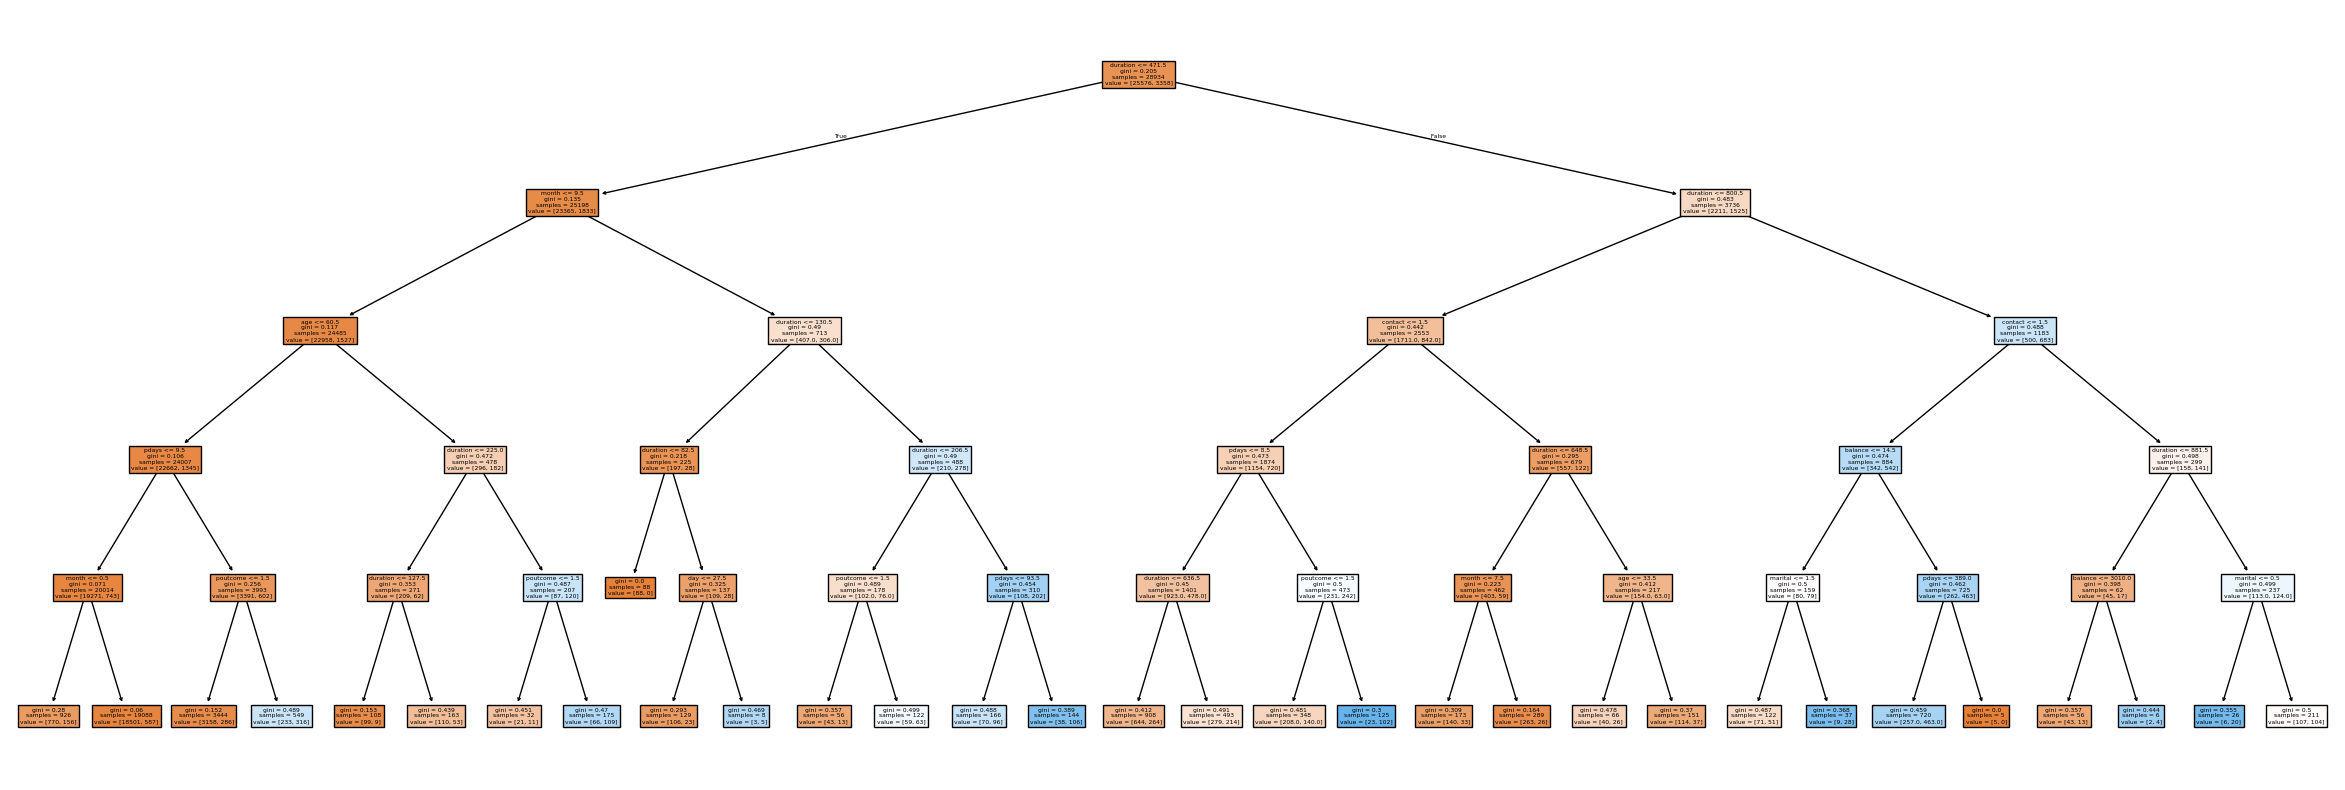

In [100]:
plt.figure(figsize=(30,10))
plot_tree(model, filled=True, feature_names= df.columns[:-1])
plt.show()

## LGBMClassifier

Documentazione modello:
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

Documentazione agiuntiva per parametri aggiuntivi: https://lightgbm.readthedocs.io/en/latest/Parameters.html

LGBMClasifier e una specia di random tree forest ma al posto di fare tanti allberi paralleli fa una serie di alberi che inparano dagli errori del albero precenende questo metodo e chiamato busting. lerning rate e quello che determina quanto un albero deve "imparare" da un albero al prossimo.

Il modello che ho fatto va in owerfitting ma non sono riuscito ad agiustarlo un po per mancanza di capacita un po per la mancanza di tempo.

**categorical_feature**: dice al modello quali delle feature passate sono categoriche. lui poi va a encodarle.

**class_weight**: ovvero il peso di una classe inconfronto a un altra. essendo che le classi sono sbilanciate sei dice al modello in modo tale che possa sopesarle meglio

**max_depht**: massimo livelli/strati/rami del albero (default=-1(overo senza limiti))

**n_estimators**: numeto di funzioni/alberi (default=100)

**is_unbalanced**: comunica se la variabile target e sbilanciata o meno (default=False)

**learning rate**: quanto impara o modifica la funzione da un itarazione al altra (default=0.1)

**min_child_sample**: il minimo di valori per fare uno split. Esempio: se e 2 puo splittare in una nuova foglia con un minimo di 2 velori da passare nella nuova foglia  (default=20)

**num_leaves**: numero massimo di foglie per albero (default= 31)

Documentazione: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


In [101]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,41,blue-collar,married,primary,849,1,unknown,15,may,72,1,-1,0,unknown,no
1,49,technician,married,primary,1415,1,cellular,30,jul,269,2,-1,0,unknown,no
2,42,admin.,married,secondary,3842,0,cellular,31,jul,130,4,-1,0,unknown,no
3,37,management,single,tertiary,-119,1,unknown,11,jun,375,11,-1,0,unknown,no
4,56,blue-collar,married,primary,3498,0,cellular,15,apr,264,2,-1,0,unknown,yes


In [102]:
y_train_l = y_train_l.map({'no': 0, 'yes': 1})
y_test_l = y_test_l.map({'no': 0, 'yes': 1})

In [103]:
cat_cols = ["job","marital","contact","month","poutcome" , "education"] # "poutcome" , "education"

for col in cat_cols:
    x_trein_l[col] = x_trein_l[col].astype("category")
    x_test_l[col] = x_test_l[col].astype("category")

In [104]:

for col in cat_cols:
    test_finale[col] = test_finale[col].astype("category")


In [105]:
n_0 = (y_train_l == 0).sum()
n_1 = (y_train_l == 1).sum()
ratio = round(n_0 / n_1, 4)
print(f"ratio: {ratio}")
print(n_0)
print(n_1)

ratio: 7.6164
25576
3358


Diamo il peso delle classi al modello in modo tale che riesca a sopesarle meglio e fare una predizione migliore per la classe meno rapresentata


In [106]:

weight = {0: 1, 1: ratio}

model = LGBMClassifier(
    random_state=42,
    class_weight=weight,
    n_estimators=550,
    num_leaves= 30,
    min_child_samples=5,
    max_depth=15
    )

model.fit(x_trein_l, y_train_l, categorical_feature=["job", "marital","contact", "month", "poutcome", "education"]) # "poutcome", "education"
y_pred_l = model.predict(x_test_l)
print(accuracy_score(y_test_l, y_pred_l))
print(classification_report(y_test_l, y_pred_l))


[LightGBM] [Info] Number of positive: 3358, number of negative: 25576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 985
[LightGBM] [Info] Number of data points in the train set: 28934, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000005
[LightGBM] [Info] Start training from score -0.000005
0.8860934476085154
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      6394
           1       0.51      0.76      0.61       840

    accuracy                           0.89      7234
   macro avg       0.74      0.83      0.77      7234
weighted avg       0.91      0.89      0.90      7234



In [107]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,41,blue-collar,married,primary,849,1,unknown,15,may,72,1,-1,0,unknown,no
1,49,technician,married,primary,1415,1,cellular,30,jul,269,2,-1,0,unknown,no
2,42,admin.,married,secondary,3842,0,cellular,31,jul,130,4,-1,0,unknown,no
3,37,management,single,tertiary,-119,1,unknown,11,jun,375,11,-1,0,unknown,no
4,56,blue-collar,married,primary,3498,0,cellular,15,apr,264,2,-1,0,unknown,yes


In [108]:
test_finale.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,40,blue-collar,married,secondary,580,1,unknown,16,may,192,1,-1,0,unknown
1,47,services,single,secondary,3644,0,unknown,9,jun,83,2,-1,0,unknown
2,25,student,single,tertiary,538,1,cellular,20,apr,226,1,-1,0,unknown
3,42,management,married,tertiary,1773,0,cellular,9,apr,311,1,336,1,failure
4,56,management,married,tertiary,217,0,cellular,21,jul,121,2,-1,0,unknown


In [109]:
y_pred_finale = model.predict(test_finale)

In [123]:
final_df = pd.DataFrame({'id': colonna_id, 'y': y_pred_finale['pred']})

In [124]:
final_df.head()


,id,y
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [126]:
# final_df.to_csv('/content/drive/MyDrive/machine learning /Verifica_intermedia_ML/Isacco_Pironato_ML_Submission.csv', index=False)

queste sono le feature piu usate dal nostro modello, quelle che lui ritiene piu importanti

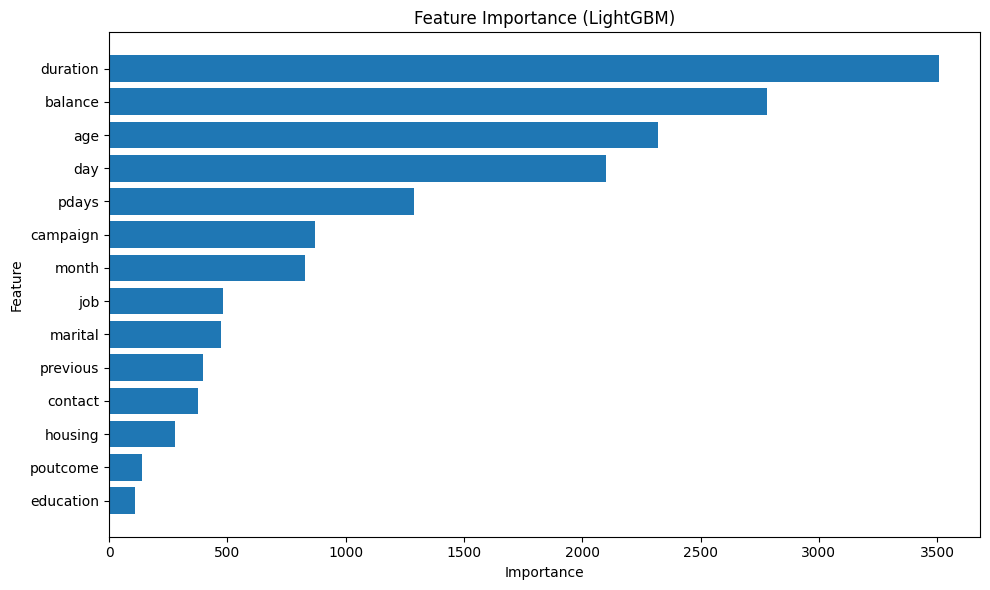

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

importances = model.feature_importances_
features = x_trein_l.columns

feat_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

feat_importances = feat_importances.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feat_importances['Feature'], feat_importances['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


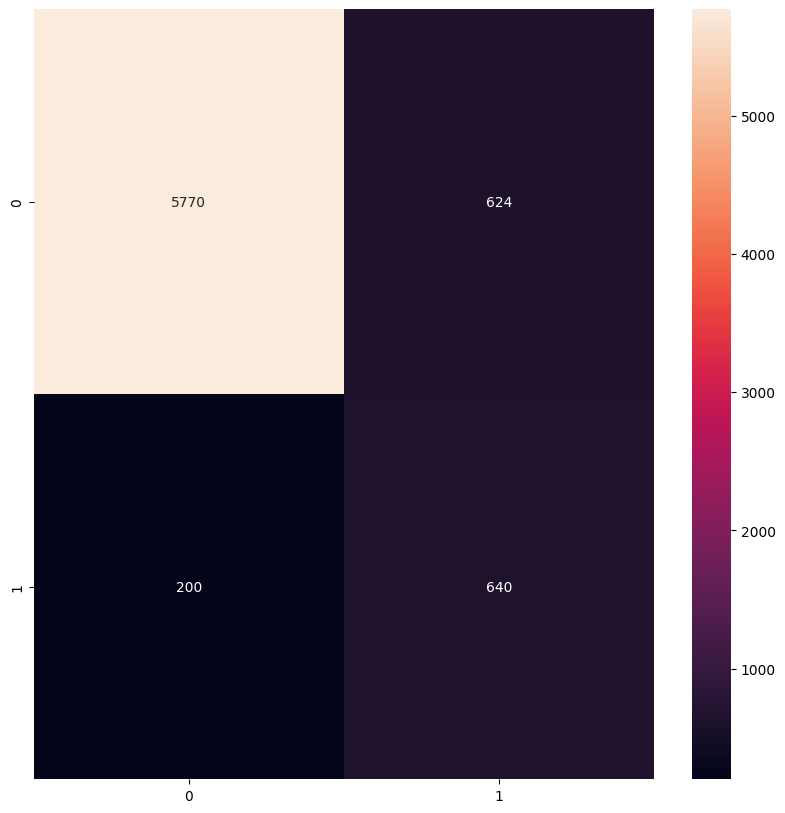

In [112]:

plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test_l, y_pred_l), annot=True, fmt='d')
plt.show()


In [113]:
y_pred_l = model.predict(x_trein_l)
print(accuracy_score(y_train_l, y_pred_l))
print(classification_report(y_train_l, y_pred_l))

0.9666827953272966
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     25576
           1       0.78      1.00      0.87      3358

    accuracy                           0.97     28934
   macro avg       0.89      0.98      0.93     28934
weighted avg       0.97      0.97      0.97     28934



In [114]:
"""
param_grid = {
  "n_estimators": [500, 550, 600],
  "learning_rate": [0.1],
  "min_child_sample": [5, 10, 15],
  "num_leaves": [30, 35],
  "class_weight": [weight],
  "max_depth": [15, 20, 25 ],
  "random_state": [42]
}


model = LGBMClassifier()

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs = -1,
    )

grid_search.fit(x_trein, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)
"""

'\nparam_grid = {\n  "n_estimators": [500, 550, 600],\n  "learning_rate": [0.1],\n  "min_child_sample": [5, 10, 15],\n  "num_leaves": [30, 35],\n  "class_weight": [weight],\n  "max_depth": [15, 20, 25 ],\n  "random_state": [42]\n}\n\n\nmodel = LGBMClassifier()\n\ngrid_search = GridSearchCV(\n    model,\n    param_grid,\n    cv=5,\n    scoring="f1_macro",\n    n_jobs = -1,\n    )\n\ngrid_search.fit(x_trein, y_train)\n\nprint("Best parameters found:", grid_search.best_params_)\nprint("Best cross-validation accuracy:", grid_search.best_score_)\n'

In [115]:
"""
model = LGBMClassifier(
    is_unbalanced = True,
    random_state = 42,
    min_child_sample = 20,
    n_estimators = 400,
    lerning_rate = 0.1,
    num_leaves = 40
    )
model.fit(x_trein, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
"""

'\nmodel = LGBMClassifier(\n    is_unbalanced = True,\n    random_state = 42,\n    min_child_sample = 20,\n    n_estimators = 400,\n    lerning_rate = 0.1,\n    num_leaves = 40\n    )\nmodel.fit(x_trein, y_train)\ny_pred = model.predict(x_test)\nprint(accuracy_score(y_test, y_pred))\nprint(classification_report(y_test, y_pred))\n'

## GaussianNB

In [116]:
model = GaussianNB()
model.fit(x_trein, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8399225877799281
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6394
           1       0.34      0.40      0.37       840

    accuracy                           0.84      7234
   macro avg       0.63      0.65      0.64      7234
weighted avg       0.85      0.84      0.85      7234



## KNN

In [117]:
model = KNeighborsClassifier()
model.fit(x_trein, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8834669615703622
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      6394
           1       0.50      0.27      0.35       840

    accuracy                           0.88      7234
   macro avg       0.70      0.62      0.64      7234
weighted avg       0.86      0.88      0.87      7234



 ## LogisticRegression

In [118]:
model = LogisticRegression()
model.fit(x_trein, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.888443461432126
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6394
           1       0.56      0.17      0.27       840

    accuracy                           0.89      7234
   macro avg       0.73      0.58      0.60      7234
weighted avg       0.86      0.89      0.86      7234



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## CatBoost


In [119]:
x_trein_finale, x_val, y_train_final, y_val = train_test_split(x_trein, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [120]:
cat_features = list(range(0, x.shape[1]))

In [121]:

clf = CatBoostClassifier(
    iterations=20,
    learning_rate=0.1,
)

clf.fit(x_trein, y_train,
        cat_features=cat_features,
        eval_set=(x_val, y_val),
        verbose=False
)

y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8942493779375172
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6394
           1       0.65      0.19      0.29       840

    accuracy                           0.89      7234
   macro avg       0.78      0.59      0.62      7234
weighted avg       0.87      0.89      0.87      7234



## Random forest Regression

In [122]:
"""
reg = RandomForestRegressor(n_estimators=100, max_features="sqrt",random_state=42)
reg.fit(x_trein, y_train)
y_pred = reg.predict(x_test)
print(accuracy_score(y_test, y_pred))
"""

'\nreg = RandomForestRegressor(n_estimators=100, max_features="sqrt",random_state=42)\nreg.fit(x_trein, y_train)\ny_pred = reg.predict(x_test)\nprint(accuracy_score(y_test, y_pred))\n'